## Fake News Detection using LSTM

#### Submitted by:
#### Jasmeet Kaur (100881373)

## Problem Statement
Fake news detection is becoming increasingly important in today's society due to the significant impact it can have on individuals and society as a whole. The spread of false or misleading information can have serious consequences, particularly when it comes to issues of public health, safety, and political decision-making.

One of the primary reasons why fake news detection is important is to protect individuals and society from harm. False information about health treatments, for example, can lead people to take ineffective or harmful medication, while false information about natural disasters can lead to people failing to evacuate, resulting in injury or death. The spread of fake news can also contribute to social unrest and political instability, as people may make decisions based on misinformation that they believe to be true.

In addition to protecting individuals and society from harm, fake news detection can also help preserve the integrity of news reporting and the media. The spread of fake news can damage the credibility of news organizations and journalists, making it difficult for people to trust the news they receive. By detecting and flagging fake news, it is possible to ensure that only accurate and reliable information is shared, helping to restore trust in the media and prevent the spread of false information.

Overall, the importance of fake news detection cannot be overstated, as it is a critical tool for promoting public safety, protecting individual rights, and preserving the integrity of news reporting and the media

## Dataset Description
Data source: Kaggle
The following are the attribtes of the rain and test dataset:
1. title: title of the news article
2. author: author of the article
3. text: text of article
4. label: 0: news is true and 1: news is fake

Total records: 20800


## Importing libraries

In [1]:
# importing necessary libraries 
import pandas as pd
import tensorflow as tf
import os
import re
import numpy as np
from string import punctuation
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# importing neural network libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

## Reading csv files and creating their copy

It's a good practice to make a copy of the data you read from a CSV file before you start modifying or processing it. This is because the original data may be needed later, and modifying it directly can cause unintended changes to the original dataset.

In addition, making a copy of the data ensures that any changes made to the copied dataset do not affect the original dataset. This is particularly important if you are working with large datasets, as modifying the original dataset directly can be computationally expensive and time-consuming.

Therefore, it's a good idea to make a copy of the data you read from a CSV file, especially if you plan on modifying or processing it in any way

In [3]:
train = pd.read_csv('/kaggle/input/fake-news/train.csv')

train_data = train.copy()


In [4]:
train_data = train_data.set_index('id', drop = True)

In [5]:
print(train_data.shape)
train_data.head()

(20800, 4)


,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data Pre Processing

In [6]:
# checking for missing values
train_data.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# dropping missing values from text columns alone. 
train_data[['title', 'author']] = train_data[['title', 'author']].fillna(value = 'Missing')
train_data = train_data.dropna()
train_data.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

Adding a new column 'length' to compute the length of the text

In [8]:
length = []
[length.append(len(str(text))) for text in train_data['text']]
train_data['length'] = length
train_data.head()

,title,author,text,label,length
id,,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938


## Finding Minimum, maximum and average length of the text

**min(train_data['length']):** This computes the minimum value of the length column in the train_data dataframe. This would be the length of the shortest news article in the training set.


**max(train_data['length']):** This computes the maximum value of the length column in the train_data dataframe. This would be the length of the longest news article in the training set.


**round(sum(train_data['length'])/len(train_data['length'])):** This computes the average value of the length column in the train_data dataframe. It does this by summing up all the values in the length column and dividing by the total number of values in the column. The round() function is used to round the result to the nearest integer. This would give you an idea of the average length of a news article in the training set

In [9]:
min(train_data['length']), max(train_data['length']), round(sum(train_data['length'])/len(train_data['length']))

(1, 142961, 4553)

Interpretation:


1.   The minimum value of 1 as size of text of the dataset implies that there are outliers present in the dataset. As small size texts represent empty text or irrelevant information that cannot be regarded as news.
2.   The computation round(sum(train_data['length'])/len(train_data['length'])) is used to get the average length of news articles in the training set. This value can be used as a guideline for determining the maximum number of features to use when training a neural network.

One common approach to representing text is use of input vectors, where each word in the text is treated as a feature, and the input vector is a binary or count-based representation of which words are present in the text. In this case, the maximum number of features would be equal to the total number of unique words in the corpus.

However, using the total number of unique words as the maximum number of features can result in an input vector that is too large, which can lead to overfitting and poor generalization. By using the average length of news articles as a guideline for the maximum number of features, we can ensure that the input vectors are reasonably sized while still capturing important information about the text.

Overall, while the exact number of features used in a neural network will depend on the specific problem and dataset, using the average length of news articles as a guideline can be a useful starting point for determining an appropriate number of features to use.









finding number of records where length of text is less than 50. These records will be considered as outliers

In [10]:
len(train_data[train_data['length'] < 50])

207

**There are 207 records with length of text less than 50**

Printing records where length of text is less than 50

In [11]:
train_data['text'][train_data['length'] < 50]

id
82                                                   
169                                                  
173                                   Guest   Guest  
196            They got the heater turned up on high.
295                                                  
                             ...                     
20350                         I hope nobody got hurt!
20418                                 Guest   Guest  
20431    \nOctober 28, 2016 The Mothers by stclair by
20513                                                
20636                              Trump all the way!
Name: text, Length: 207, dtype: object

These are mostly empty texts and therefore should be removed in data pre processing stage

In [12]:
# dropping the outliers
train_data = train_data.drop(train_data['text'][train_data['length'] < 50].index, axis = 0)

Now, again let's compute the minimum, maximum and average length of the text

In [13]:
min(train_data['length']), max(train_data['length']), round(sum(train_data['length'])/len(train_data['length']))

(50, 142961, 4598)

Now, as stated above we can ensure that the input vectors are reasonably sized while still capturing important information about the text by assigning max_features as the average value of the length of text, that is 4600

In [14]:
max_features = 4600

## Data Visualization

Generating word clouds for fake news and true news

In [26]:
!pip install wordcloud

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

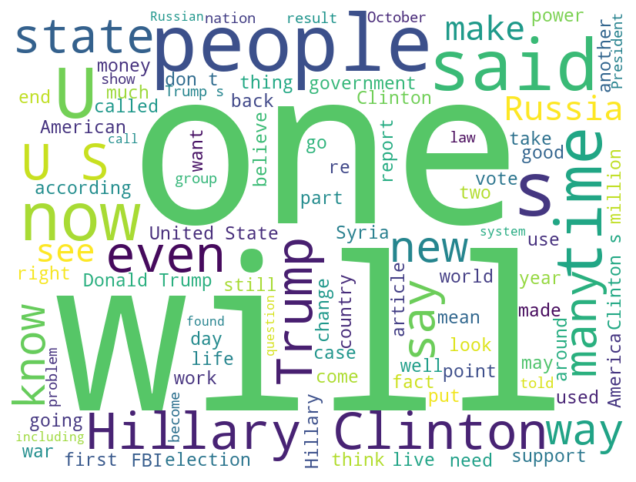

In [33]:
wc = WordCloud(width=800, height=600, background_color='white', max_words=100)

# Generate a word cloud for transformed content of fake news articles with label 1
fake_news_wc = wc.generate(train_data[train_data['label'] == 1]['text'].str.cat(sep=" "))

# Display the word cloud
plt.figure(figsize=(8,6))
plt.imshow(fake_news_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

The fake news articles majorly have words like election, Trump, Hillary, Russia, FBI ec.

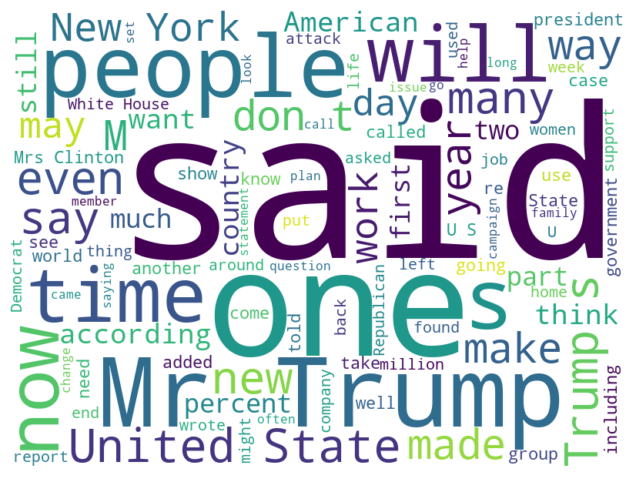

In [35]:
wc = WordCloud(width=800, height=600, background_color='white', max_words=100)

# Generate a word cloud for transformed content of true news articles with label 0
fake_news_wc = wc.generate(train_data[train_data['label'] == 0]['text'].str.cat(sep=" "))

# Display the word cloud
plt.figure(figsize=(8,6))
plt.imshow(fake_news_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

The true news articles mainly have words like said, time, people, United State etc.

## Data Preparation

Next step is **Tokenization:** 
Tokenizing is the process of converting text into a numerical representation that can be used as input for a machine learning algorithm. In the code you provided, the Tokenizer class from the Keras library is used to tokenize the text data.

In [15]:
# Tokenizing the text - converting the words, letters into counts or numbers. 
# We dont need to explicitly remove the punctuations. we have an inbuilt option in Tokenizer for this purpose
tokenizer = Tokenizer(num_words = max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts = train_data['text'])
X = tokenizer.texts_to_sequences(texts = train_data['text'])

**Interpretation:**
The Tokenizer class has several parameters that can be set to customize the tokenization process. The num_words parameter specifies the maximum number of words to keep, based on word frequency. The filters parameter specifies which characters to filter out from the text data. In this case, all punctuation marks and special characters are filtered out. The lower parameter specifies whether to convert all text to lowercase, and the split parameter specifies the character used to split the text into tokens.

After the Tokenizer is initialized with the desired parameters, the fit_on_texts method is called to fit the tokenizer on the training data. This method updates the internal vocabulary based on the frequency of words in the training data.

Finally, the texts_to_sequences method is used to convert the text data into a sequence of integers, where each integer corresponds to a specific word in the vocabulary. The resulting X variable contains the tokenized text data that can be used as input for a machine learning algorithm.

In [16]:
# now applying padding to make them even shaped.
X = pad_sequences(sequences = X, maxlen = max_features, padding = 'pre')

Padding is a technique used in natural language processing to make all sequences in a dataset the same length. In the code you provided, the pad_sequences function from the Keras library is used to pad the tokenized text sequences.

The pad_sequences function takes in the tokenized sequences as input, along with the maxlen parameter, which specifies the maximum length of the padded sequences. In this case, the maxlen parameter is set to the value of max_features, which is the maximum number of words to keep in the vocabulary.

The padding parameter specifies whether to pad the sequences before or after the text. In this case, 'pre' is used, which means that the padding is added before the text. This ensures that all sequences have the same length, regardless of their original length.

The resulting X variable contains the padded tokenized text sequences, which can be used as input for a machine learning algorithm.

In [17]:
print(X.shape)
y = train_data['label'].values
print(y.shape)

(20554, 4600)
(20554,)


## Splitting the Dataset

The train_test_split function from the scikit-learn library is used to split the data into training and testing sets. In the code you provided, the X and y variables represent the input features and output targets respectively.

The test_size parameter specifies the proportion of the data to be used for testing. In this case, it is set to 0.2, which means that 20% of the data will be used for testing and 80% for training.

The random_state parameter sets the random seed for the random number generator used by the train_test_split function. This ensures that the same split is obtained each time the code is run, making the results reproducible.

The resulting X_train, X_test, y_train, and y_test variables contain the training and testing data, which can be used to train and evaluate the machine learning model.

In [18]:
# splitting the data training data for training and validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

## Model Selection and Implementation - LSTM Model

I am **using LSTM Model becaue**: <br>

Long Short-Term Memory (LSTM) models are a type of Recurrent Neural Network (RNN) that are commonly used for natural language processing tasks such as text classification, language translation, and speech recognition.

LSTM models are particularly well-suited for sequential data such as text, as they are able to capture the context and dependencies between words in a sentence. They have the ability to remember long-term dependencies and to selectively forget irrelevant information, which makes them effective for tasks that require analyzing text with long-term dependencies.

Fake news prediction is a task that requires analyzing the text of a news article to determine whether it is likely to be true or false. This involves analyzing the context and dependencies between words in the article to identify patterns that distinguish between real and fake news.

LSTM models are effective for this task because they are able to capture the context and dependencies between words in a sentence, and to learn patterns in the data that can be used to distinguish between real and fake news. By training an LSTM model on a large dataset of news articles, it is possible to develop a model that can accurately predict whether a news article is likely to be real or fake.

### Model Implementation

In [19]:
# LSTM Neural Network
lstm_model = Sequential(name = 'lstm_nn_model')
lstm_model.add(layer = Embedding(input_dim = max_features, output_dim = 120, name = '1st_layer'))
lstm_model.add(layer = LSTM(units = 120, dropout = 0.2, recurrent_dropout = 0.2, name = '2nd_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '3rd_layer'))
lstm_model.add(layer = Dense(units = 120,  activation = 'relu', name = '4th_layer'))
lstm_model.add(layer = Dropout(rate = 0.5, name = '5th_layer'))
lstm_model.add(layer = Dense(units = len(set(y)),  activation = 'sigmoid', name = 'output_layer'))
# compiling the model
lstm_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


The following is the **explanation of the implementation of the model:**

This model is designed to be an LSTM-based neural network for the purpose of predicting fake news. Here is a breakdown of the layers and their functions:

Embedding layer: This layer creates a dense vector representation for each word in the input sequence. The input_dim parameter specifies the size of the vocabulary, which is set to max_features, and the output_dim parameter specifies the size of the embedding vector, which is set to 120.

LSTM layer: This layer contains LSTM units that process the input sequence and produce a hidden state for each time step. The units parameter specifies the number of LSTM units in the layer, which is set to 120. The dropout and recurrent_dropout parameters are used to prevent overfitting by randomly dropping out inputs and outputs during training.

Dropout layer: This layer randomly drops out inputs to prevent overfitting. The rate parameter specifies the fraction of inputs to drop, which is set to 0.5.

Dense layer: This layer applies a fully connected neural network to the output of the LSTM layer. The units parameter specifies the number of neurons in the layer, which is set to 120. The activation parameter specifies the activation function for the layer, which is set to 'relu'.

Dropout layer: This layer is the same as the previous dropout layer and drops out inputs to prevent overfitting.

Dense layer: This is the output layer of the model and applies a fully connected neural network to the output of the previous dropout layer. The units parameter specifies the number of neurons in the layer, which is set to the number of unique labels in the target variable y. The activation parameter specifies the activation function for the layer, which is set to 'sigmoid'.

The model is compiled using the 'adam' optimizer, which is an efficient stochastic gradient descent algorithm.

The loss function is set to 'sparse_categorical_crossentropy', which is used for multi-class classification problems where the target variable y is sparse. In the case of sparse_categorical_crossentropy, the true labels are integers instead of one-hot encoded vectors. This means that each label can be represented by a single integer value, and there is no need to convert the labels to a one-hot encoded format before training the model. This loss function is commonly used in classification problems where the number of classes is large, and one-hot encoding of the labels would result in high memory usage. In the case of fake news prediction, where we have only two classes (real or fake), using sparse_categorical_crossentropy is a good choice because it is more memory-efficient than one-hot encoding, and provides a good measure of the model's performance on the binary classification task. 

The metric for evaluation is set to 'accuracy', which is a standard metric for classification problems.



In [20]:
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 1)

514/514 [==============================] - 11381s 22s/step - loss: 0.3141 - accuracy: 0.8732


The model has accuracy of 87.32% on training dataset


## Model Evaluation and Interpretation

Accuracy is a commonly used metric for evaluating the performance of a classification model, including an LSTM model. It measures the proportion of correctly classified instances out of all instances in the dataset.

In [24]:
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.9360253214836121


The model has accuracy of 93.6% on test dataset

**Interpretation and Conclsion**: <br>
The accuracy of the training dataset is 0.87 and the accuracy of the test dataset is 0.93, this suggests that the LSTM model is performing well on the test data, and is not overfitting the training data.

An accuracy of 0.87 on the training data means that the model correctly classified 87% of the instances in the training set. This is a reasonable accuracy, but it is important to also evaluate the model's performance on the test data to ensure that it generalizes well to unseen data.

An accuracy of 0.93 on the test data means that the model correctly classified 93% of the instances in the test set. This is a good accuracy and suggests that the model is performing well on the test data. 

Overall, an accuracy of 0.93 on the test data suggests that the LSTM model is effective in classifying fake news and can be used as a reliable tool for this task.